# Evaluation AIMY

## Imports

In [1]:
import os
import sys
import pathlib

sys.path.append(str(pathlib.Path(os.getcwd()).parent.absolute()))

path = "plots"
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)

import tikzplotlib
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator

Load unified plot style.

In [2]:
import seaborn as sns

text_color = "#222222"
sns.set(
    font="Arial",
    rc={
        "axes.axisbelow": True,
        "axes.edgecolor": "grey",
        "axes.facecolor": "whitesmoke",
        "axes.grid": False,
        "axes.labelcolor": text_color,
        "axes.spines.right": True,
        "axes.spines.top": True,
        "axes.titlecolor": "black",
        "grid.color": "white",
        "figure.constrained_layout.use": True,
        "figure.facecolor": "None",
        "figure.titlesize": 16,
        "figure.titleweight": "bold",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": text_color,
        "xtick.bottom": True,
        "xtick.color": text_color,
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": text_color,
        # "ytick.direction": "out",
        "ytick.left": True,
        "ytick.right": False,
        "savefig.dpi": 300,
    },
)

sns.set_context(
    "paper",
    rc={"font.size": 12, "axes.titlesize": 14, "axes.labelsize": 12},
)

Use LaTeX-font and annotations.

LaTeX interpreter causes problems in Ubuntu, for me the following packages solved the issues: 
> sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

In [3]:
import matplotlib as mpl

mpl.rcParams["text.usetex"] = True  # requires pip install cm-super
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Computer Modern Roman"
mpl.rcParams["font.sans-serif"] = "Computer Modern Sans Serif"
mpl.rcParams["font.monospace"] = "Computer Modern Typewriter"

In [4]:
from aimy_target_shooting.custom_types import TrajectoryCollection
from aimy_target_shooting.hitpoint_utils import sort_hitpoints_by_occurrance, std, mean
from aimy_target_shooting.utility import confidence_ellipse

from aimy_target_shooting import (
    export_tools,
    hitpoint_detection,
    hitpoint_utils,
)

## Visualisation functions

In [5]:
def add_table_2d(ax: plt.axes):
    table = plt.Rectangle(
        (-1.525 / 2, 0),
        1.525,
        2.74,
        facecolor="dimgray",
        alpha=0.45,
        zorder=1,
    )

    table_frame = plt.Rectangle(
        (-1.525 / 2, 0),
        1.525,
        2.74,
        linewidth=8,
        facecolor="none",
        edgecolor="white",
        zorder=1,
    )

    ax.add_patch(table)
    ax.add_patch(table_frame)

    ax.vlines(0.0, 0.0, 2.74, linewidth=3, color="white", zorder=1)
    ax.hlines(
        2.74 / 2,
        -1.525 / 2,
        1.525 / 2,
        linewidth=6,
        color="gray",
        zorder=1,
    )

In [6]:
def add_hitpoints_plot(
    trajectory_collection: TrajectoryCollection,
    ax: plt.axes,
    color_iterator=None,
    vertical: bool = False,
):
    hitpoint_axis = trajectory_collection.get_item(0)["axis"]

    axis = [0, 1, 2]
    axis.remove(hitpoint_axis)

    if color_iterator is not None:
        color = next(color_iterator)
    else:
        color = None

    x = []
    y = []

    for sample in trajectory_collection:
        hitpoints = np.array(sample["hitpoints"])

        if hitpoints.size == 0:
            continue

        x.append(hitpoints[:, axis[0]])
        y.append(hitpoints[:, axis[1]])

    if not vertical:
        ax.scatter(x, y, color=color, alpha=0.8, edgecolor=None)
    else:
        ax.scatter(y, x, color=color, alpha=0.8, edgecolor=None)

In [7]:
def add_mean_plot(
    trajectory_collection: TrajectoryCollection, ax: plt.axes, vertical: bool = False
):
    hitpoint_axis = trajectory_collection.get_item(0)["axis"]

    axis = [0, 1, 2]
    axis.remove(hitpoint_axis)

    ordered_hitpoints = sort_hitpoints_by_occurrance(trajectory_collection)

    mean_values = []
    for hitpoints in ordered_hitpoints:
        if len(hitpoints) < 3:
            continue

        mean_values.append(tuple(np.mean(hitpoints, axis=0)))

    mu = np.array(mean_values)

    if mu.size != 0:
        if not vertical:
            ax.scatter(mu[:, axis[0]], mu[:, axis[1]], c="#333333", marker="X", s=72)
        else:
            ax.scatter(mu[:, axis[1]], mu[:, axis[0]], c="#333333", marker="X", s=72)

In [8]:
def add_confidence_ellipses(
    trajectory_collection: TrajectoryCollection,
    ax: plt.axes,
    n_std=4.0,
    vertical: bool = False,
):
    hitpoint_axis = trajectory_collection.get_item(0)["axis"]

    axis = [0, 1, 2]
    axis.remove(hitpoint_axis)

    ordered_hitpoints = sort_hitpoints_by_occurrance(trajectory_collection)
    if ordered_hitpoints:
        for hitpoints in ordered_hitpoints:
            if len(hitpoints) < 3:
                continue

            hitpoints = np.array(hitpoints)

            if not vertical:
                confidence_ellipse(
                    hitpoints[:, axis[0]],
                    hitpoints[:, axis[1]],
                    ax=ax,
                    n_std=n_std,
                    edgecolor="#333333",
                )
            else:
                confidence_ellipse(
                    hitpoints[:, axis[1]],
                    hitpoints[:, axis[0]],
                    ax=ax,
                    n_std=n_std,
                    edgecolor="#333333",
                )

In [9]:
def add_annotation(
    trajectory_collection: TrajectoryCollection,
    ax: plt.axes,
    target: int,
    annotation_shift: float = 0.1,
):

    mu = np.array(mean(trajectory_collection)[0])
    dev = np.array(std(trajectory_collection)[0])

    mu = mu + 0.045

    value_font_color = "#333333"
    value_font_size = 9

    n = len(trajectory_collection)
    A_sigma = round((dev[0] + dev[1]) / 2, 3)

    ax.annotate(
        f"Target {target}",
        (annotation_shift + dev[1] + mu[1], mu[0]),
        ha="left",
        va="bottom",
        color="black",
    )

    ax.annotate(
        f"$n={n}$\n$" + r"\|\mathbf{\sigma}\|" + f"={A_sigma}$",
        (annotation_shift + dev[1] + mu[1], mu[0] - 0.02),
        ha="left",
        va="top",
        color=value_font_color,
        fontsize=value_font_size,
    )

In [10]:
def plot_parameter_comparison(trajectory_collection_list) -> None:
    """Plots several centered hitpoint plots.

    Args:
        trajectory_collection_list (List[TrajectoryCollection]):
        List of collections of trajectories.

    """
    split = False

    rows = 1
    columns = len(trajectory_collection_list)

    if columns > 4:
        rows = 2
        columns = int(np.ceil(columns / 2))
        split = True

    fig, axs = plt.subplots(
        rows,
        columns,
        figsize=(16.18, 4),
    )

    fig.align_labels()

    for index, trajectory_collection in enumerate(trajectory_collection_list):
        if split:
            if index >= columns:
                i = 1
                j = index - columns
            else:
                i = 0
                j = index
            index = (i, j)

        hitpoint_axis = trajectory_collection.get_item(0)["axis"]

        mean_value = list(mean(trajectory_collection)[0])
        del mean_value[hitpoint_axis]

        xwindow = 0.3
        ywindow = 0.3

        axs[index].set_xlim([mean_value[0] - xwindow / 2, mean_value[0] + xwindow / 2])
        axs[index].set_ylim([mean_value[1] - ywindow / 2, mean_value[1] + ywindow / 2])

        add_hitpoints_plot(trajectory_collection, axs[index])
        add_mean_plot(trajectory_collection, axs[index])
        add_confidence_ellipses(trajectory_collection, axs[index])

    return fig, axs

## Accuracy Evaluation various Ball Launcher

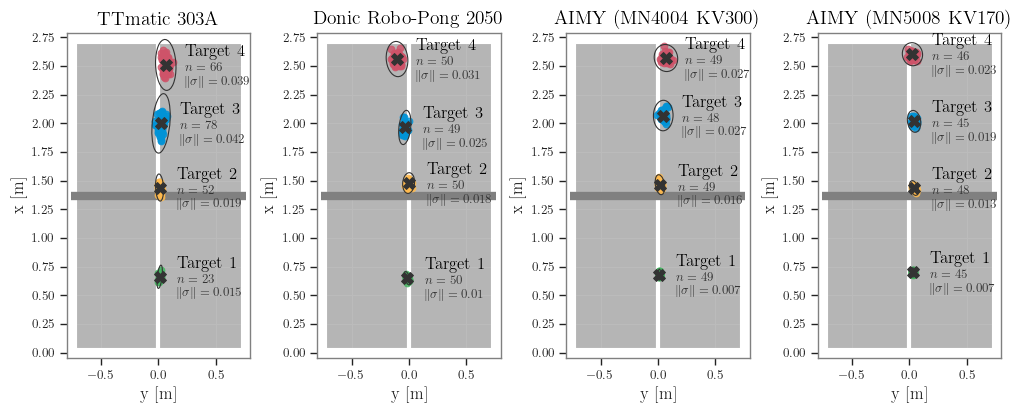

In [11]:
# Measurements with v1
v1_dir = pathlib.Path(
    "/home/adittrich/nextcloud/82_Data_Processed/303A_accuracy_distance"
)
v1_data = []
v1_data.append("303A_medium_angle_target_1.hdf5")
v1_data.append("303A_medium_angle_target_2.hdf5")
v1_data.append("303A_medium_angle_target_3.hdf5")
v1_data.append("303A_medium_angle_target_4.hdf5")

# Measurements with v2
MN4004_dir = pathlib.Path(
    "/home/adittrich/nextcloud/82_Data_Processed/MN4004_accuracy_distance"
)
MN4004_data = []
MN4004_data.append("MN4004_medium_angle_target_1.hdf5")
MN4004_data.append("MN4004_medium_angle_target_2.hdf5")
MN4004_data.append("MN4004_medium_angle_target_3.hdf5")
MN4004_data.append("MN4004_medium_angle_target_4.hdf5")

# Measurements with v3
MN5008_dir = pathlib.Path(
    "/home/adittrich/nextcloud/82_Data_Processed/MN5008_accuracy_distance"
)
MN5008_data = []
MN5008_data.append("MN5008_medium_angle_target_1.hdf5")
MN5008_data.append("MN5008_medium_angle_target_2.hdf5")
MN5008_data.append("MN5008_medium_angle_target_3.hdf5")
MN5008_data.append("MN5008_medium_angle_target_4.hdf5")

# Measurements with v3
PP_dir = pathlib.Path(
    "/home/adittrich/nextcloud/82_Data_Processed/PP_accuracy_distance"
)
PP_data = []
PP_data.append("PP_medium_angle_target_1.hdf5")
PP_data.append("PP_medium_angle_target_2.hdf5")
PP_data.append("PP_medium_angle_target_3.hdf5")
PP_data.append("PP_medium_angle_target_4.hdf5")

# Preprocessing data
detection = hitpoint_detection.HitPointDetection()

# Loading and Preprocessing
tc_v1 = []
for filename in v1_data:
    data = export_tools.import_all_from_hdf5(file_path=v1_dir / filename)
    data = detection.evaluate_hitpoints(data)
    data = hitpoint_utils.remove_further_hitpoints(data)

    tc_v1.append(data)

tc_v2 = []
for filename in MN4004_data:
    data = export_tools.import_all_from_hdf5(file_path=MN4004_dir / filename)
    data = detection.evaluate_hitpoints(data)
    data = hitpoint_utils.remove_further_hitpoints(data)

    tc_v2.append(data)

tc_v3 = []
for filename in MN5008_data:
    data = export_tools.import_all_from_hdf5(file_path=MN5008_dir / filename)
    data = detection.evaluate_hitpoints(data)
    data = hitpoint_utils.remove_further_hitpoints(data)

    tc_v3.append(data)

tc_v4 = []
for filename in PP_data:
    data = export_tools.import_all_from_hdf5(file_path=PP_dir / filename)
    data = detection.evaluate_hitpoints(data)
    data = hitpoint_utils.remove_further_hitpoints(data)

    tc_v4.append(data)

# Plotting
trajectory_collection_lists = [tc_v1, tc_v4, tc_v2, tc_v3]
launcher_names = [
    "TTmatic 303A",
    "Donic Robo-Pong 2050",
    "AIMY (MN4004 KV300)",
    "AIMY (MN5008 KV170)",
]

mpi_colors = ["#46b361", "#ffba4d", "#0193d7", "#cf5369", "#46b361", "#006c66"]

fig, axs = plt.subplots(1, len(trajectory_collection_lists), figsize=(10, 16.18))

fig.set_size_inches(10.00, 4.0)
fig.align_labels()

for i, tc in enumerate(trajectory_collection_lists):
    axs[i].set_ylabel("x [m]")
    axs[i].set_xlabel("y [m]")

    axs[i].set_aspect("equal")
    axs[i].grid()

    add_table_2d(axs[i])

    x_lim = (-0.05, 2.79)
    y_lim = (-1.60 / 2, 1.60 / 2)
    z_lim = (0.76, 0.76 + 1.525)
    limits = [x_lim, y_lim, z_lim]

    axs[i].set_ylim(limits[0][0], limits[0][1])
    axs[i].set_xlim(limits[1][0], limits[1][1])

    color_iter = iter(mpi_colors)

    for j, trajectory_collection in enumerate(tc):
        add_hitpoints_plot(
            trajectory_collection, axs[i], color_iterator=color_iter, vertical=True
        )
        add_mean_plot(trajectory_collection, axs[i], vertical=True)
        add_confidence_ellipses(trajectory_collection, axs[i], n_std=4.0, vertical=True)
        add_annotation(trajectory_collection, axs[i], target=j + 1)


for i, ax in enumerate(axs):
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.set_title(launcher_names[i])

fig.savefig("plots/launcher_comparison.pdf", bbox_inches="tight")

## System Parameter Analysis

### Orientation jumps

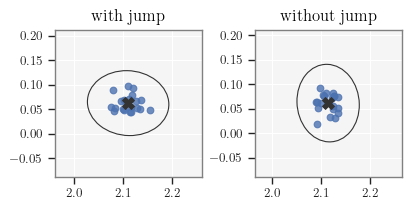

In [12]:
dir = pathlib.Path(
    "/home/adittrich/nextcloud/82_Data_Processed/MN5008_accuracy_orientation_jump"
)

data_name_list = []

data_name_list.append("MN5008_with_orientation_jump.hdf5")
data_name_list.append("MN5008_without_orientation_jump.hdf5")


# Hitpoint detection setup
detection = hitpoint_detection.HitPointDetection()

# Data loading and preprocessing
tc_list = []
for filename in data_name_list:
    # Loading
    data = export_tools.import_all_from_hdf5(file_path=dir / filename)

    # Hitpoint evaluation
    data = detection.evaluate_hitpoints(data)
    data = hitpoint_utils.remove_further_hitpoints(data)

    tc_list.append(data)

# Visualisation
fig, axs = plot_parameter_comparison(tc_list)

# fig.suptitle("Orientation Jump Evaluation")
fig.set_size_inches(4.0, 2.0)

axs[0].set_title("with jump", fontsize=12)
axs[1].set_title("without jump", fontsize=12)

for i in range(len(data_name_list)):
    axs[i].grid()
    axs[i].set_aspect("equal")

fig.savefig("plots/landing_points_jump.pdf")

### Ball Pinching

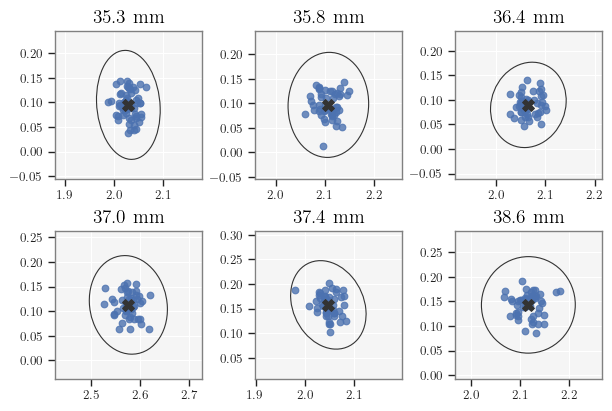

In [13]:
dir = pathlib.Path(
    "/home/adittrich/nextcloud/82_Data_Processed/MN5008_accuracy_ball_pinch"
)

MN5008_t1 = "MN5008_35.3mm_pinch.hdf5"
MN5008_t2 = "MN5008_35.8mm_pinch.hdf5"
MN5008_t3 = "MN5008_36.4mm_pinch.hdf5"
MN5008_t4 = "MN5008_37.0mm_pinch.hdf5"
MN5008_t5 = "MN5008_37.4mm_pinch.hdf5"
MN5008_t6 = "MN5008_38.6mm_pinch.hdf5"

data_list = [MN5008_t1, MN5008_t2, MN5008_t3, MN5008_t4, MN5008_t5, MN5008_t6]

detection = hitpoint_detection.HitPointDetection()

tc_list = []

for name in data_list:
    # Loading data
    data = export_tools.import_all_from_hdf5(file_path=dir / name)

    # Hitpoint evaluation
    data = detection.evaluate_hitpoints(data)
    data = hitpoint_utils.remove_further_hitpoints(data)

    tc_list.append(data)

# Plotting
fig, axs = plot_parameter_comparison(tc_list)
# fig.suptitle("Ball Pinching Evaluation")
fig.set_size_inches(6.0, 4.0)

for index, value in enumerate(
    ["35.3 mm", "35.8 mm", "36.4 mm", "37.0 mm", "37.4 mm", "38.6 mm"]
):
    if index >= int(np.ceil(len(tc_list) / 2)):
        i = 1
        j = index - len(tc_list)
    else:
        i = 0
        j = index
    index = (i, j)

    axs[index].set_title(value)
    axs[index].grid()
    axs[index].set_aspect("equal")

fig.savefig("plots/landing_points_pinching.pdf")

### Ramp-up Times

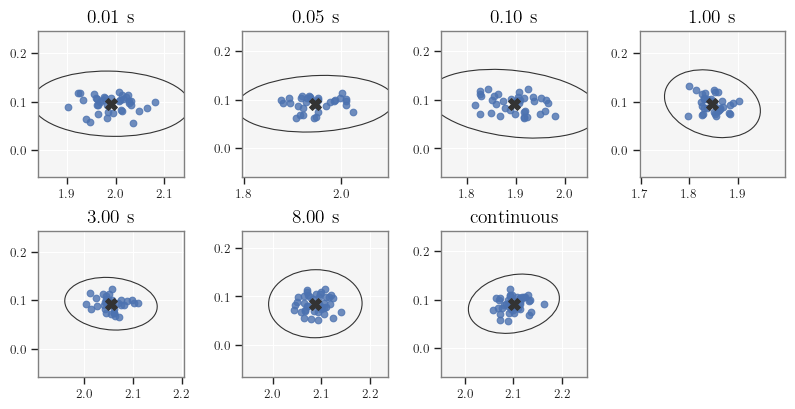

In [14]:
dir = pathlib.Path(
    "/home/adittrich/nextcloud/82_Data_Processed/MN5008_accuracy_startup_times"
)

data_name_list = []

data_name_list.append("MN5008_startuptime_0.01s.hdf5")
data_name_list.append("MN5008_startuptime_0.05s.hdf5")
data_name_list.append("MN5008_startuptime_0.10s.hdf5")
data_name_list.append("MN5008_startuptime_1.00s.hdf5")
data_name_list.append("MN5008_startuptime_3.00s.hdf5")
data_name_list.append("MN5008_startuptime_8.00s.hdf5")
data_name_list.append("MN5008_startuptime_continuous.hdf5")

# Hitpoint detection setup
detection = hitpoint_detection.HitPointDetection()

# Data loading and preprocessing
tc_list = []
for filename in data_name_list:
    # Loading
    data = export_tools.import_all_from_hdf5(file_path=dir / filename)

    # Hitpoint evaluation
    data = detection.evaluate_hitpoints(data)
    data = hitpoint_utils.remove_further_hitpoints(data)

    tc_list.append(data)

# Visualisation
fig, axs = plot_parameter_comparison(tc_list)

# fig.suptitle("Launch delay evaluation")
fig.set_size_inches(8.0, 4.0)

for index, value in enumerate(
    ["0.01 s", "0.05 s", "0.10 s", "1.00 s", "3.00 s", "8.00 s", "continuous"]
):

    if index >= int(np.ceil(len(tc_list) / 2)):
        i = 1
        j = index - len(tc_list) - 1
    else:
        i = 0
        j = index
    index = (i, j)

    axs[index].set_title(value)
    axs[index].grid()
    axs[index].set_aspect("equal")

fig.delaxes(axs[1, 3])

fig.savefig("plots/landing_points_rampup.pdf")

### Stroke Speed

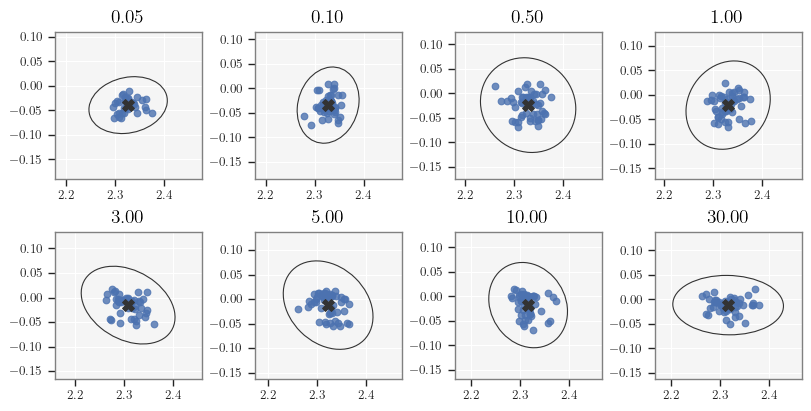

In [15]:
dir = pathlib.Path(
    "/home/adittrich/nextcloud/82_Data_Processed/MN5008_accuracy_strokespeed"
)

data_name_list = []

data_name_list.append("MN5008_strokespeed_0.05.hdf5")
data_name_list.append("MN5008_strokespeed_0.10.hdf5")
data_name_list.append("MN5008_strokespeed_0.50.hdf5")
data_name_list.append("MN5008_strokespeed_1.00.hdf5")
data_name_list.append("MN5008_strokespeed_3.00.hdf5")
data_name_list.append("MN5008_strokespeed_5.00.hdf5")
data_name_list.append("MN5008_strokespeed_10.00.hdf5")
data_name_list.append("MN5008_strokespeed_30.00.hdf5")

# Hitpoint detection setup
detection = hitpoint_detection.HitPointDetection()

# Data loading and preprocessing
tc_list = []
for filename in data_name_list:
    # Loading
    data = export_tools.import_all_from_hdf5(file_path=dir / filename)

    # Hitpoint evaluation
    data = detection.evaluate_hitpoints(data)
    data = hitpoint_utils.remove_further_hitpoints(data)

    tc_list.append(data)

# Visualisation
fig, axs = plot_parameter_comparison(tc_list)

# fig.suptitle("Stroke Speed evaluation")
fig.set_size_inches(8.0, 4.00)

for index, value in enumerate(
    ["0.05", "0.10", "0.50", "1.00", "3.00", "5.00", "10.00", "30.00"]
):
    if index >= int(len(tc_list) / 2):
        i = 1
        j = index - len(tc_list)
    else:
        i = 0
        j = index
    index = (i, j)

    axs[index].set_title(value)
    axs[index].grid()
    axs[index].set_aspect("equal")

fig.savefig("plots/landing_points_strokegain.pdf")

### Overall parameters comparison

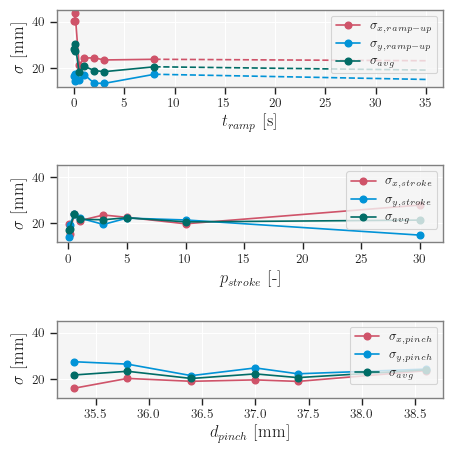

In [16]:
# Hitpoint detection setup
detection = hitpoint_detection.HitPointDetection()

# Rampup
dir = pathlib.Path(
    "/home/adittrich/nextcloud/82_Data_Processed/MN5008_accuracy_startup_times"
)
data_name_list = []
data_name_list.append("MN5008_startuptime_0.01s.hdf5")
data_name_list.append("MN5008_startuptime_0.05s.hdf5")
data_name_list.append("MN5008_startuptime_0.10s.hdf5")
data_name_list.append("MN5008_startuptime_0.50s.hdf5")
data_name_list.append("MN5008_startuptime_1.00s.hdf5")
data_name_list.append("MN5008_startuptime_2.00s.hdf5")
data_name_list.append("MN5008_startuptime_3.00s.hdf5")
data_name_list.append("MN5008_startuptime_8.00s.hdf5")
data_name_list.append("MN5008_startuptime_continuous.hdf5")

t = [0.01, 0.05, 0.1, 0.5, 1.0, 2.0, 3.0, 8.0, 35.0]
std_x_rampup = []
std_y_rampup = []

for filename in data_name_list:
    # Loading
    data = export_tools.import_all_from_hdf5(file_path=dir / filename)
    # Hitpoint evaluation
    data = detection.evaluate_hitpoints(data)
    data = hitpoint_utils.remove_further_hitpoints(data)

    std = hitpoint_utils.std(data)
    std_x_rampup.append(std[0][0])
    std_y_rampup.append(std[0][1])


# Stroke Gain
dir = pathlib.Path(
    "/home/adittrich/nextcloud/82_Data_Processed/MN5008_accuracy_strokespeed"
)
data_name_list = []
data_name_list.append("MN5008_strokespeed_0.05.hdf5")
data_name_list.append("MN5008_strokespeed_0.10.hdf5")
data_name_list.append("MN5008_strokespeed_0.50.hdf5")
data_name_list.append("MN5008_strokespeed_1.00.hdf5")
data_name_list.append("MN5008_strokespeed_3.00.hdf5")
data_name_list.append("MN5008_strokespeed_5.00.hdf5")
data_name_list.append("MN5008_strokespeed_10.00.hdf5")
data_name_list.append("MN5008_strokespeed_30.00.hdf5")

gain = [0.05, 0.10, 0.50, 1.00, 3.00, 5.00, 10.00, 30.00]
std_x_strokegain = []
std_y_strokegain = []

for filename in data_name_list:
    # Loading
    data = export_tools.import_all_from_hdf5(file_path=dir / filename)
    # Hitpoint evaluation
    data = detection.evaluate_hitpoints(data)
    data = hitpoint_utils.remove_further_hitpoints(data)

    std = hitpoint_utils.std(data)
    std_x_strokegain.append(std[0][0])
    std_y_strokegain.append(std[0][1])


# Ball Pinching
dir = pathlib.Path(
    "/home/adittrich/nextcloud/82_Data_Processed/MN5008_accuracy_ball_pinch"
)
data_name_list = []
data_name_list.append("MN5008_35.3mm_pinch.hdf5")
data_name_list.append("MN5008_35.8mm_pinch.hdf5")
data_name_list.append("MN5008_36.4mm_pinch.hdf5")
data_name_list.append("MN5008_37.0mm_pinch.hdf5")
data_name_list.append("MN5008_37.4mm_pinch.hdf5")
data_name_list.append("MN5008_38.6mm_pinch.hdf5")

pinch = [35.3, 35.8, 36.4, 37.0, 37.4, 38.6]
std_x_pinch = []
std_y_pinch = []

for filename in data_name_list:
    # Loading
    data = export_tools.import_all_from_hdf5(file_path=dir / filename)

    # Hitpoint evaluation
    data = detection.evaluate_hitpoints(data)
    data = hitpoint_utils.remove_further_hitpoints(data)

    std = hitpoint_utils.std(data)
    std_x_pinch.append(std[0][0])
    std_y_pinch.append(std[0][1])


# Average
std_x_rampup = 1000 * np.array(std_x_rampup)
std_y_rampup = 1000 * np.array(std_y_rampup)
avg_rampup = np.mean([std_x_rampup, std_y_rampup], axis=0)

std_x_strokegain = 1000 * np.array(std_x_strokegain)
std_y_strokegain = 1000 * np.array(std_y_strokegain)
avg_strokegain = np.mean([std_x_strokegain, std_y_strokegain], axis=0)

std_x_pinch = 1000 * np.array(std_x_pinch)
std_y_pinch = 1000 * np.array(std_y_pinch)
avg_pinch = np.mean([std_x_pinch, std_y_pinch], axis=0)

# Visualisation
fig, axs = plt.subplots(3, 1, sharey=True, constrained_layout=False)
fig.set_size_inches(5, 5)

t_1 = t[0:-1]
axs[0].plot(
    t_1, std_x_rampup[0:-1], "o-", label=r"$\sigma_{x,ramp-up}$", color="#CF5369"
)
axs[0].plot(
    t_1, std_y_rampup[0:-1], "o-", label=r"$\sigma_{y,ramp-up}$", color="#0193d7"
)
axs[0].plot(t_1, avg_rampup[0:-1], "o-", label=r"$\sigma_{avg}$", color="#006c66")

t_2 = t[-2:]
axs[0].plot(t_2, std_x_rampup[-2:], "--", color="#CF5369")
axs[0].plot(t_2, std_y_rampup[-2:], "--", color="#0193d7")
axs[0].plot(t_2, avg_rampup[-2:], "--", color="#006c66")
axs[0].set_xlabel(r"$t_{ramp}$ [s]")
axs[0].set_ylabel(r"$\sigma$ [mm]")

axs[1].plot(gain, std_x_strokegain, "o-", label=r"$\sigma_{x,stroke}$", color="#CF5369")
axs[1].plot(gain, std_y_strokegain, "o-", label=r"$\sigma_{y,stroke}$", color="#0193d7")
axs[1].plot(gain, avg_strokegain, "o-", label=r"$\sigma_{avg}$", color="#006c66")
axs[1].set_xlabel(r"$p_{stroke}$ [-]")
axs[1].set_ylabel(r"$\sigma$ [mm]")
axs[1].set_xlim([-1, 32])

axs[2].plot(pinch, std_x_pinch, "o-", label=r"$\sigma_{x,pinch}$", color="#CF5369")
axs[2].plot(pinch, std_y_pinch, "o-", label=r"$\sigma_{y,pinch}$", color="#0193d7")
axs[2].plot(pinch, avg_pinch, "o-", label=r"$\sigma_{avg}$", color="#006c66")
axs[2].set_xlabel(r"$d_{pinch}$ [mm]")
axs[2].set_ylabel(r"$\sigma$ [mm]")

for ax in axs:
    ax.grid()
    ax.legend(loc=1)

fig.tight_layout(pad=2.0)

fig.savefig("plots/system_parameter.pdf")